In [164]:
# %matplotlib notebook
# %matplotlib inline
import numpy as np
np.random.seed(123)
import collections, copy, pickle
from importlib import reload
from dateutil.parser import parse
import scipy.linalg, scipy.stats
import pandas as pd
import sklearn
# import scipy.sparse
# import scipy.sparse.linalg
# import matplotlib
# import matplotlib.transforms
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
# import mpl_toolkits.mplot3d.axes3d as p3
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib import cm
# from matplotlib.ticker import LinearLocator, FormatStrFormatter
# from matplotlib import animation
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14
# rcParams['text.usetex'] = True
import seaborn as sns
from IPython.display import HTML
# from numba import jit, njit, float32, prange
# import cProfile

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [199]:
import util.plot
import util.data

In [200]:
reload(util.plot)
reload(util.data)

<module 'util.data' from '/Users/mark/stack/doc/school/Data Mining Techniques/lab/util/data.py'>

Generate a clean db with
```
python3 clean_odi.py
```

In [5]:
# %ls

In [6]:
data = pd.read_csv('ODI-2019-clean.csv', sep=';')

In [7]:
data.describe()

,Unnamed: 0,Stress level,Day,Month,Year,Neighbours,Money
count,276.000000,276.000000,262.000000,262.000000,201.000000,261.000000,276.000000
mean,137.500000,38.500000,13.778626,6.419847,1993.985075,4.877395,35.241884
std,79.818544,33.933571,8.917493,3.411619,3.464791,8.174556,40.238578
min,0.000000,0.000000,0.000000,0.000000,1969.000000,0.000000,0.000000
25%,68.750000,10.000000,5.000000,4.000000,1993.000000,2.000000,1.000000
50%,137.500000,30.000000,13.000000,6.000000,1995.000000,3.000000,10.000000
75%,206.250000,65.000000,21.000000,9.000000,1996.000000,6.000000,80.000000
max,275.000000,100.000000,31.000000,12.000000,2001.000000,80.000000,100.000000


In [8]:
data.head()

,Unnamed: 0,Timestamp,ML,IR,Stat,DB,Gender,Chocolate,Stand up,Rand,Good day (1),Good day (2),Stress level,Programme,Day,Month,Year,Neighbours,Money,Bedtime
0,0,3/27/2019 10:16:11,Yes,Yes,Yes,Yes,unknown,Slim,no,6,sun,lecture,30.0,AI,NaN,NaN,NaN,3.0,100.0,23:00:00
1,1,4/1/2019 15:58:21,No,No,Yes,Yes,male,Fat,no,7,DM,AI,1.0,AI,9.0,7.0,1992.0,1.0,0.0,03:00:00
2,2,4/1/2019 15:59:07,Yes,Yes,Unknown,Yes,male,Neither,unknown,0,0,0,100.0,CS,4.0,8.0,1995.0,0.0,0.0,00:00:00
3,3,4/1/2019 15:59:30,Yes,Yes,Yes,Yes,male,Fat,no,"1,645",Winning,Food,0.0,ECONOMETRICS,29.0,9.0,1993.0,2.0,42.0,00:30:00
4,4,4/1/2019 15:59:58,No,Yes,Yes,Yes,male,Neither,no,66,kiss,love,100.0,CS,5.0,4.0,NaN,2.0,10.0,20:00:00


In [11]:
# {i:k for i,k in enumerate(data.keys())}

In [12]:
# keys = {'What programme are you in?': 'Program',
#         'Have you taken a course on machine learning?': 'ML',
#         'Have you taken a course on information retrieval?': 'IR',
#         'Have you taken a course on statistics?': 'Stat',
#         'Have you taken a course on databases?': 'DB'}
# data.rename(index=str, columns=keys, inplace=True)
# # df.rename(index=str, columns={"A": "a", "B": "c"})
# data.keys()

In [13]:
# categorical = ['Program','ML','IR','DB','Stat']
numerical = ['Year', 'Money', 'Neighbours', 'Stress level']
categorical = list(data.keys())
for label in numerical:
    categorical.remove(label)
# irrelevant
categorical.remove('Timestamp')
categorical.remove('Unnamed: 0')
categorical.remove('Month')
categorical.remove('Day')
categorical.remove('Rand') # numerical & noisy
categorical.remove('Bedtime') # numerical & noisy
# too many categories
categorical.remove('Good day (1)')
categorical.remove('Good day (2)')
categorical.remove('Programme')
categorical

['ML', 'IR', 'Stat', 'DB', 'Gender', 'Chocolate', 'Stand up']

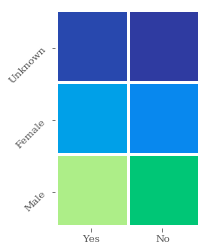

In [201]:
# reload(util.data)

r = util.data.summarize_categorical(data, 'ML', 'Gender')
# r = {'A':{'e':0.9,'f':0.1, 'g':0.2}, 'B':{'e':0.1, 'f':0.1, 'g':0.3}, 'C':{'e':0.1, 'f':0.1, 'g':0.3}}
with plt.style.context(('ggplot')):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plot_summary(ax, r)
    
# TODO rm weird vertical line

In [193]:
reload(util.plot)

# def plot_correlations(data, keys, conditional_x=False, include_diagonal=True):
#     rcParams['font.size'] = 14 
#     n_items = -1
#     n_keys = len(keys)
#     if not include_diagonal:
#         n_keys -= 1

#     with plt.style.context(('ggplot')):
#         fig = plt.figure(figsize=(3*n_keys, 2*n_keys))
#         # x
#         for i_x, k_x in enumerate(keys):
#             # y
#             for i_y, k_y in enumerate(keys):
#                 plot = False
#                 if include_diagonal and i_x <= i_y:
#                     plot = True
#                     ax = fig.add_subplot(n_keys, n_keys, i_x + i_y * n_keys + 1)
#                 elif not include_diagonal and i_x < i_y:
#                     ax = fig.add_subplot(n_keys, n_keys, i_x + (i_y - 1) * n_keys + 1)
                    
#                 if plot:
#                     plot_correlation(ax, data, i_x, k_x, i_y, k_y, n_keys, conditional_x)

#         plt.tight_layout()

# def plot_correlation(ax, data, i_x, k_x, i_y, k_y, n_keys, conditional_x):
#     if k_x in categorical:
#         categories_x = data[k_x].unique()
#         if k_y in categorical:
#             categories_y = data[k_y].unique()
#             # summarize
#             summary = summarize_categorical(data, k_x, k_y, conditional_x)
#             cb = plot_summary(ax, summary);
#             # show colorbar
#             #  cb()
#         else:
#             # summarize
#             print('TODO \t', k_x, k_y)
#             pass
#     else:
#         x = getattr(data, k_x)
#         y = getattr(data, k_y)
#         x = to_floats(x)
#         y = to_floats(y)
#         x,y = filter_nans(x,y)        
#         if k_x == k_y:
#             # plot hist + kde curve (approximated distribution)
#             sns.distplot(x, hist=True, kde=True, color='darkgreen')
#         else:
#             plt.scatter(x, y, s=9, alpha=0.8)
#             # compute correlation (symmetric for x,y)
# #             x = np.array(x)[~np.isnan(x)]
# #             y = np.array(y)[~np.isnan(y)][:x.size]
#             r,p = scipy.stats.pearsonr(x, y)
#             significant = 'significant' if p < 0.05 else 'not significant'
#             print('%s ~ %s: \t %s \t p-value: %0.4f, c: %0.4f' % (k_x, k_y, significant, p, r))
            
#             # fit regression line (asymmetric for x,y)
#             xy_pred, _result = util.plot.regression(x, y, line=True, v=0)
#             plt.plot(xy_pred[:,0], xy_pred[:,1], color='black', lw=1, alpha=0.9)
    
#     if i_x == 0:
#         plt.ylabel(k_y)
#     if i_y == n_keys:
#         plt.xlabel(k_x)

<module 'util.plot' from '/Users/mark/stack/doc/school/Data Mining Techniques/lab/util/plot.py'>

In [194]:
# x = np.random.random(9) *2
# sns.distplot(x)

Year ~ Money: 	 not significant 	 p-value: 0.7563, c: -0.0220
Year ~ Neighbours: 	 not significant 	 p-value: 0.8016, c: -0.0183
Year ~ Stress level: 	 not significant 	 p-value: 0.1572, c: -0.1002
Money ~ Neighbours: 	 significant 	 p-value: 0.0372, c: 0.1290
Money ~ Stress level: 	 not significant 	 p-value: 0.2877, c: -0.0642
Neighbours ~ Stress level: 	 not significant 	 p-value: 0.2111, c: 0.0777


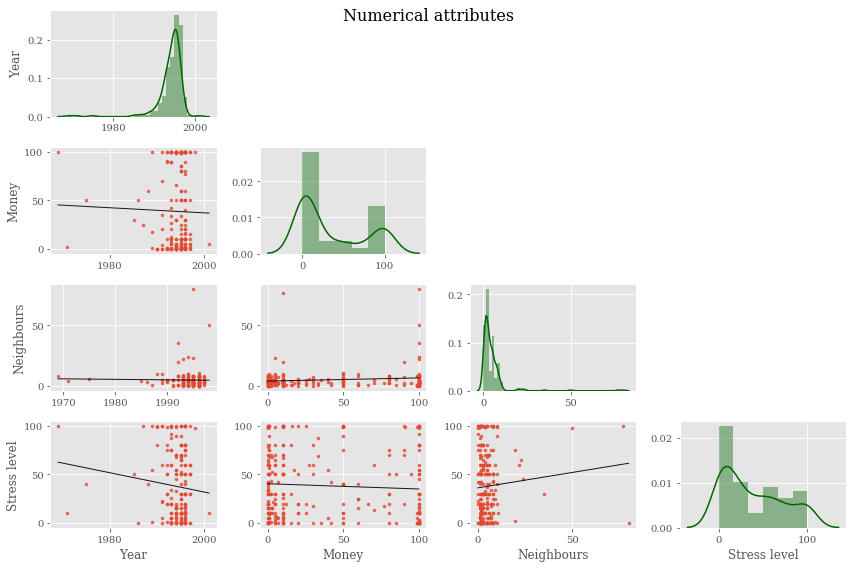

In [229]:
reload(util.plot)
reload(util.data)

# data = pd.read_csv('ODI-2019-clean.csv', sep=';')
# fig = plt.figure(figsize=(9,6))
util.plot.correlation_grid(data, numerical)
plt.suptitle('Numerical attributes', fontsize=16)
util.plot.savefig('Correlations-grid')

6 6


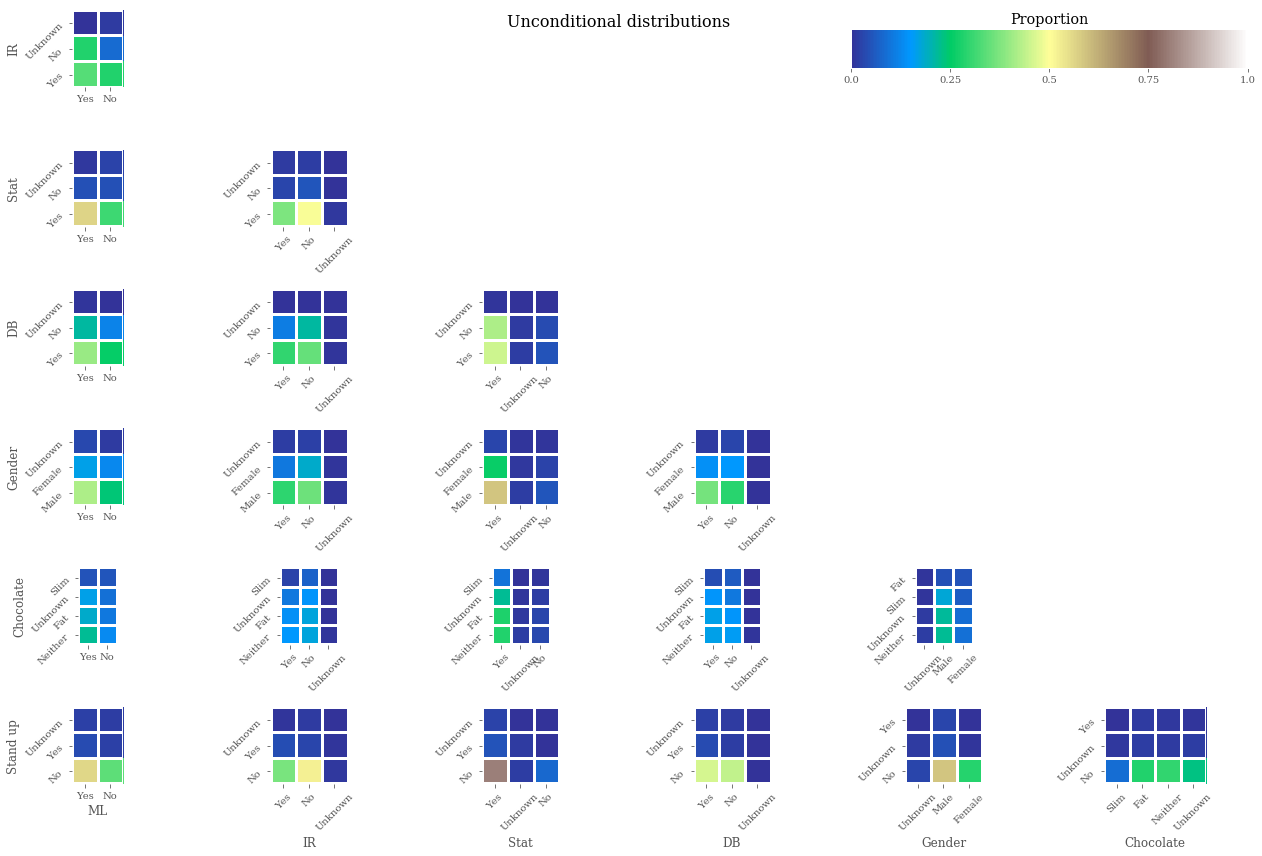

In [314]:
reload(util.plot)
reload(util.data)

util.plot.correlation_grid(data, categorical, numerical=False)
plt.suptitle('Unconditional distributions', fontsize=16)
util.plot.savefig('Unconditional-distributions-grid')

6 6


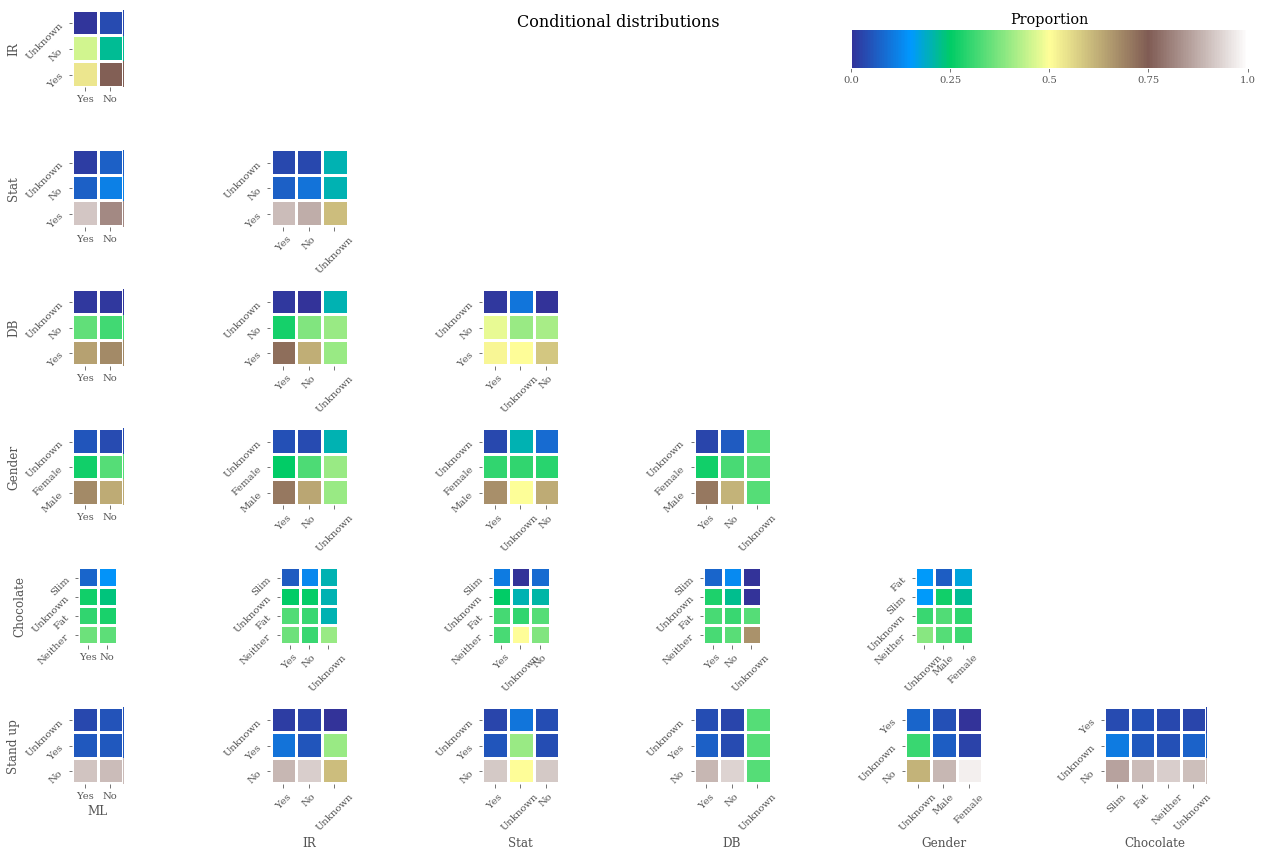

In [315]:
util.plot.correlation_grid(data, categorical, conditional_x=True, numerical=False)
plt.suptitle('Conditional distributions', fontsize=16)
util.plot.savefig('Conditional-distributions-grid')

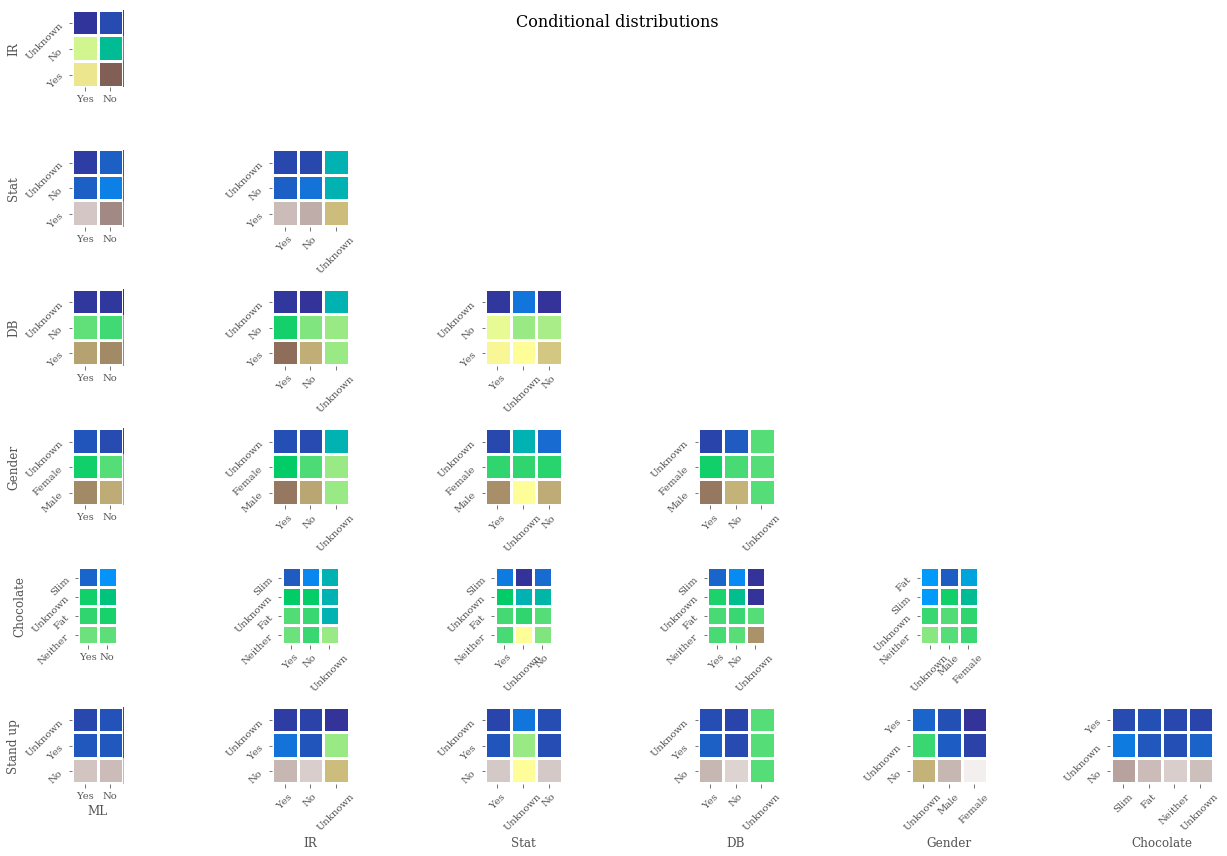

In [38]:
plot_correlations(data, categorical, conditional_x=True)
plt.suptitle('Conditional distributions', fontsize=16)
util.plot.savefig('Conditional-distributions-grid')